### Лабораторная работа 9. Проект

Постановка задачи. Выделить на фоне всего изображения интересующие нас объекты. Создать таблицу признаков для сформированного набора объектов. Провести распознавание этих объектов с помощью нейронной сети.

Импорт библиотек

In [1]:
import cv2
import numpy as np
# Модуль контуров
from collections import Counter #
# Модуль кластерного анализа
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

def imgshow(image, conversion=cv2.COLOR_BGR2RGB):
    image = cv2.cvtColor(image, conversion)
    plt.imshow(image)
    plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()

#### На первом этапе проводится предварительная обработка изображений, которая включает в себя удаление шума, повышение резкости изображений. С помощью этой обработки выделяются характерные детали, подавляется шум, повышается быстродействие, уменьшается объем информации.

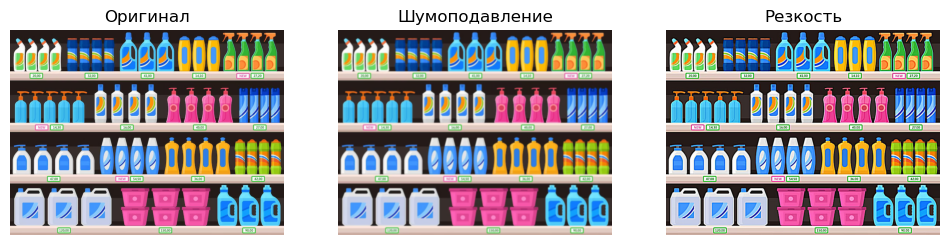

In [2]:
image = cv2.imread('images/img.jpg')

denoised = cv2.GaussianBlur(image, (5, 5), 0)
sharped = cv2.filter2D(denoised, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
plt.title('Шумоподавление')
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2.cvtColor(sharped, cv2.COLOR_BGR2RGB))
plt.title('Резкость')
plt.axis('off')
plt.show();

#### Следующий шаг – удалении фона на изображении, для этого сканируется все пространство изображения и отсканированные пиксели с одинаковой интенсивностью обнуляются. В результате интересующие нас объекты будут более четко выделены на черном фоне.

Функция shelf() предназначена для удаления фона. В процессе работы этой программы сканируется все строки, начиная с 
верхней. Если при сканировании интенсивности пикселей не меняются, то они обнуляются. В результате на изображении фон становится 
темным

In [3]:
def shelf(img, k=120):
    img_copy = np.copy(img)
    x = 0
    for i in range(img_copy.shape[1]):
        if x > ((img_copy.shape[1]) / 1.01):
            img_copy[i - 1] = [0, 0, 0]
            img_copy[i - 2] = [0, 0, 0]
            x = 0
        for j in range(img_copy.shape[0]):
            if (img_copy[i][0][0] - k <= img_copy[i][j][0] <= img_copy[i][0][0] + k) and (
                    img_copy[i][0][1] - k <= img_copy[i][j][1] <= img_copy[i][0][1] + k) and (
                    img_copy[i][0][2] - k <= img_copy[i][j][2] <= img_copy[i][0][2] + k):
                x += 1
    return img_copy.astype(np.uint8)

(-0.5, 799.5, 799.5, -0.5)

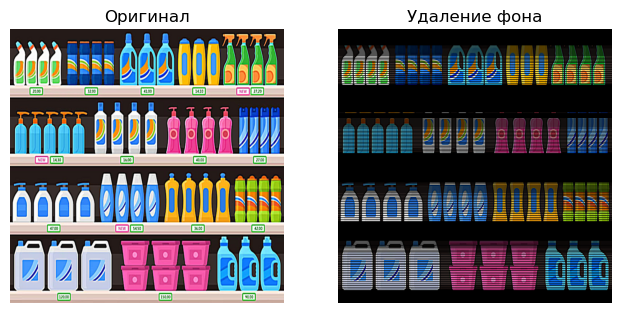

In [4]:
img = cv2.resize(sharped, (800, 800))
shelfed = shelf(img, k=75)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(shelfed, cv2.COLOR_BGR2RGB))
plt.title('Удаление фона')
plt.axis('off')

#### Для выделения объектов используется операция сегментации изображения методом водораздела, с последующей маркировкой результата сегментации.

Функция segment() предназначена для разбиения всего поля изображени на сегменты, с последующей их маркировкой

In [5]:
def segment(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Преобразование изображения в черно-белое с использованием порогового значения
    _, im_bw = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # Применение морфологической операции открытия для удаления шума
    kernel = np.ones((4, 3), np.uint8)
    opening = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Дилатация для получения фона
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    
    # Вычисление преобразования расстояния для определения переднего плана
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)
    ret, sure_fg = cv2.threshold(dist_transform, 0.01 * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)
    
    # Обнаружение границы между фоном и передним планом
    unknown = cv2.Canny(sure_bg, 700, 100, apertureSize=3)
        
    # Маркировка компонентов связности
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown]
    
    # Применение алгоритма водораздела
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]
    
    return [img, im_bw, unknown]


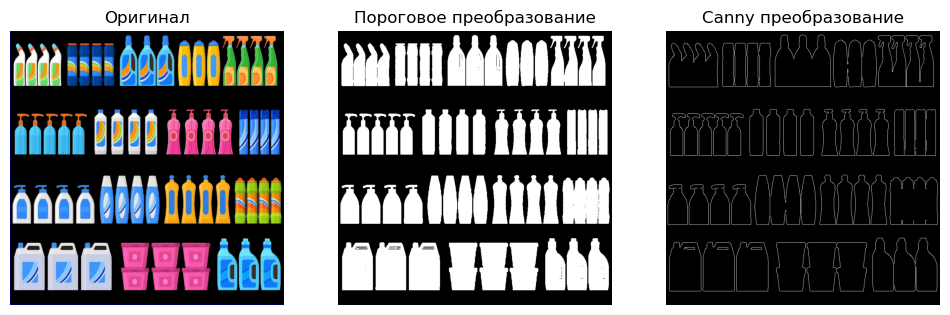

In [6]:
# Загружаем изображение
image = cv2.imread('images/imgb.jpg')
img = cv2.resize(image, (800, 800))
marker = segment(img)

# Возвращаем обработанное изображение
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')

plt.subplot(132)
plt.imshow(cv2.cvtColor(marker[1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Пороговое преобразование')

plt.subplot(133)
plt.imshow(cv2.cvtColor(marker[2], cv2.COLOR_BGR2RGB))
plt.title('Canny преобразование')
plt.axis('off')
plt.show()

#### С помощью операции распознавания объекта по шаблону каждый объект охватывается прямоугольной рамкой. Распознавание объекта по шаблону.

Метод заключается в поиске объекта на большом изображении, который соответствует выбранному шаблону. Поиск проводится с помощью функции cv2.matchTemplate(). Шаблон перемещается по исходному изображению, его пиксели сравниваются с пикселями этого изображения. На выходе получаем изображение в градациях серого.

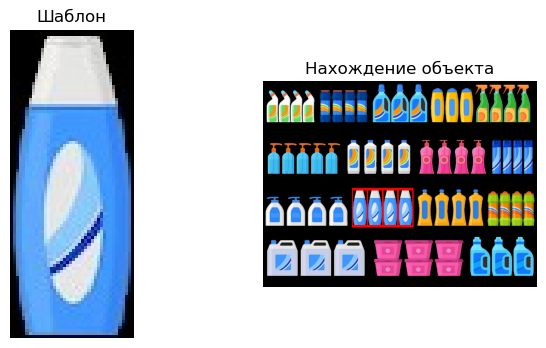

In [7]:
image = cv2.imread('images/imgb.jpg')
template = cv2.imread('images/template.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)

threshold = 0.8
loc = np.where(result >= threshold)

for pt in zip(*loc[::-1]):
    cv2.rectangle(image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0, 0, 255), 1)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('Шаблон')
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
plt.title('Нахождение объекта')
plt.axis('off')
plt.show();

Приведение объектов распознавания к единому размеру. Для правильного создания признаков объектов их нужно привести к одинаковому размеру по высоте. Для этого у каждого объекта определяем коэффициент пересчета k = h1/h0, где h0 – стандартная высота, в нашем случае h0 = 160, h1 – старая высота. Тогда новая ширина равна w = w1* h1/h0.

In [8]:
image = cv2.imread('images/imgb.jpg', 1)
s = image.shape  # Получаем размер исходного изображения
h1, w1 = s[0], s[1]  # Запоминаем отдельно высоту и ширину
wr = round(77 * h1 / 160)
img = cv2.resize(image, (wr, 113))  # изменяем размер
cv2.imwrite("img/r1.jpg", img)
print(s)
print(w1)

(555, 740, 3)
740


### Создание таблицы признаков

Приведение объектов распознавания к единому размеру. Для правильного создания признаков объектов их нужно привести к одинаковому размеру по высоте. Для этого у каждого объекта определяем коэффициент пересчета k = h1/h0, где h0 – стандартная высота, в нашем случае h0 = 160, h1 – старая высота. Тогда новая ширина равна w = w1* h1/h0 применим операцию бинаризации. Первый аргумент – матрица серого изображения; второй – значение интенсивности монохромного изображения в случае, когда интенсивность серого изображения больше порога, если меньше, то интенсивность монохромного изображения равна нулю; третий задает адаптивную бинаризацию серого изображения.

На основе массива точек изображения и массива координат контура вычисляются все признаки объекта.

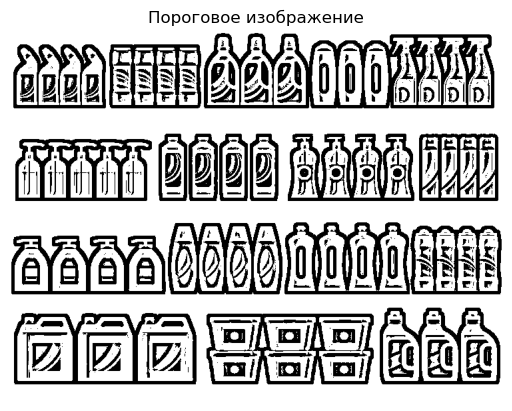

Координата x: 0
Координата y: 0
Ширина прямоугольника: 740
Высота прямоугольника: 555


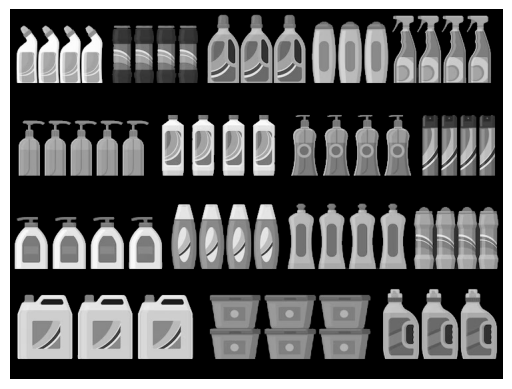

In [9]:
img = cv2.imread('images/imgb.jpg', 0)

# Применение адаптивной бинаризации для получения бинарного изображения
th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Отображение бинарного изображения
plt.imshow(th, cmap='gray')
plt.title('Пороговое изображение')
plt.axis('off')
plt.show()

# Нахождение контуров на бинарном изображении
contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]

# Вычисление параметров контура
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)

hull = cv2.convexHull(cnt) # выпуклая оболочка

# Ограничивающий прямоугольник контура
x, y, w, h = cv2.boundingRect(cnt)

# Рисование ограничивающего прямоугольника на изображении
image_with_rectangle = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

print("Координата x:", x)
print("Координата y:", y)
print("Ширина прямоугольника:", w)
print("Высота прямоугольника:", h)

imgshow(image_with_rectangle)

In [10]:
# Вычисление дополнительных параметров контура
epsilon = 0.1 * cv2.arcLength(cnt, True)
aspect_ratio = float(w) / h
rect_area = w * h
extent = float(area) / rect_area
hull_area = cv2.contourArea(hull)
equi_diameter = np.sqrt(4 * area / np.pi)

# Создание маски для контура
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1);

# Вычисление моментов контура
M = cv2.moments(cnt)

pixelpoints = np.transpose(np.nonzero(mask))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img, mask=mask)

# Нахождение самых левой, правой, верхней и нижней точки контура
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

# Выво значений параметров
print("Площадь:", area)
print("Периметр:", perimeter)
print("Ширина, Высота:", w, h)
print("Соотношение сторон:", aspect_ratio)
print("Отношение площади к ограничивающему прямоугольнику:", extent)
print("Площадь выпуклой оболочки:", hull_area)
print("Эквивалентный диаметр:", equi_diameter)
print("Моменты:", M)
print("Самая левая точка:", leftmost)
print("Самая правая точка:", rightmost)
print("Самая верхняя точка:", topmost)
print("Самая нижняя точка:", bottommost)

Площадь: 409406.0
Периметр: 2586.0
Ширина, Высота: 740 555
Соотношение сторон: 1.3333333333333333
Отношение площади к ограничивающему прямоугольнику: 0.9968492817141466
Площадь выпуклой оболочки: 409406.0
Эквивалентный диаметр: 721.9916267186511
Моменты: {'m00': 409406.0, 'm10': 151275517.0, 'm01': 113405462.0, 'm20': 74528404708.66666, 'm11': 41903318209.0, 'm02': 41884417298.666664, 'm30': 41307368309778.5, 'm21': 20644368104300.668, 'm12': 15476292191857.334, 'm03': 17402975387596.0, 'mu20': 18632101177.166656, 'mu11': 0.0, 'mu02': 10471104324.666664, 'mu30': 0.0078125, 'mu21': 0.00390625, 'mu12': 0.00146484375, 'mu03': 0.001953125, 'nu20': 0.11116125150421172, 'nu11': 0.0, 'nu02': 0.0624718087505638, 'nu30': 7.284580090811824e-17, 'nu21': 3.642290045405912e-17, 'nu12': 1.365858767027217e-17, 'nu03': 1.821145022702956e-17}
Самая левая точка: (0, 0)
Самая правая точка: (739, 554)
Самая верхняя точка: (0, 0)
Самая нижняя точка: (0, 554)


### Создание таблицы признаков

In [11]:
s = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
p = [157.55, 141.34, 90.476, 1262.1, 61.799, 78.064, 175.47, 48.730]
w = [31, 51, 7, 66, 15, 5, 24, 5]
h = [54, 26, 41, 158, 22, 37, 70, 22]
kw = [0.574, 1.9615, 0.1707, 0.4177, 0.6818, 0.1351, 0.3429, 0.2272]
ks = [0.7461, 0.4351, 0.6289, 0.7475, 0.4939, 0.6, 0.5414, 0.2682]
d = [39.878, 27.105, 15.160, 99.627, 14.406, 11.888, 34.029, 6.1287]
m0 = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
m1 = [15994, 18479, 3319.8, 255475, 790.83, 174.5, 8059.0, 40.833]
m2 = [27883, 4990.2, 1440.7, 616222, 1220.3, 2033.3, 21165, 160.5]
m3 = [307788, 175877, 180.5, 19613900, 4657.8, 3300.2, 153434, 152.375]
weights = [0.3, 0.5, 0.1, 0.2, 1, 1, 1, 1, 1, 1, 1]

def sum(a, b):
    assert(len(a) == len(b))
    output = 0
    for i in range(len(a)):
        output += (a[i] * b[i])
    return output

def art_neuron(input, weights):
    pred = sum(input, weights)
    return pred

in0 = [s[0], p[0], w[0], h[0], kw[0], ks[0], d[0], m0[0], m1[0], m2[0], m3[0]]
in1 = [s[1], p[1], w[1], h[1], kw[1], ks[1], d[1], m0[1], m1[1], m2[1], m3[1]]
in2 = [s[2], p[2], w[2], h[2], kw[2], ks[2], d[2], m0[2], m1[2], m2[2], m3[2]]
in3 = [s[3], p[3], w[3], h[3], kw[3], ks[3], d[3], m0[3], m1[3], m2[3], m3[3]]
in4 = [s[4], p[4], w[4], h[4], kw[4], ks[4], d[4], m0[4], m1[4], m2[4], m3[4]]
in5 = [s[5], p[5], w[5], h[5], kw[5], ks[5], d[5], m0[5], m1[5], m2[5], m3[5]]

print("Входные данные 0:", in0)
print("Входные данные 5:", in5)

Входные данные 0: [1249.0, 157.55, 31, 54, 0.574, 0.7461, 39.878, 1249.0, 15994, 27883, 307788]
Входные данные 5: [111.0, 78.064, 5, 37, 0.1351, 0.6, 11.888, 111.0, 174.5, 2033.3, 3300.2]


По значениям на выходе нейронной сети можно провести распознавание неизвестного объекта из множества объектов

In [12]:
pred0 = art_neuron(in0, weights)
pred1 = art_neuron(in1, weights)
pred2 = art_neuron(in2, weights)
pred3 = art_neuron(in3, weights)
pred4 = art_neuron(in4, weights)
pred5 = art_neuron(in5, weights)

print("Результат предсказания 0:", pred0)
print("Результат предсказания 1:", pred1)
print("Результат предсказания 2:", pred2)
print("Результат предсказания 3:", pred3)
print("Результат предсказания 4:", pred4)
print("Результат предсказания 5:", pred5)

Результат предсказания 0: 353422.5731
Результат предсказания 1: 200206.7716
Результат предсказания 2: 5245.747600000001
Результат предсказания 3: 20496501.1922
Результат предсказания 4: 6933.2112
Результат предсказания 5: 5711.8551
